# Feature 9 : BERT semantic similarity score

## Applying the BERTscore semantic similarity metric

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_FOLDER = "../data/"
PATHS_AND_GRAPH = DATA_FOLDER + "wikispeedia_paths-and-graph/"
PATHS_FINISHED = PATHS_AND_GRAPH + "paths_finished.tsv"
PATHS_UNFINISHED = PATHS_AND_GRAPH + "paths_unfinished.tsv"

# data exploration
paths_finished = pd.read_csv(
    PATHS_FINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    encoding="utf-8",
    skiprows=16,
).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit="s")

paths_unfinished = pd.read_csv(
    PATHS_UNFINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit="s")

# Remove annoying future warnings in pandas and seaborn with new python versions
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained(
    "dslim/bert-base-NER"
)  # Named entity recognition-specific model!


def compute_sim(s1, s2):
    enc1 = tokenizer.encode(s1, return_tensors="pt").reshape(1, -1)
    enc2 = tokenizer.encode(s2, return_tensors="pt").reshape(1, -1)

    trunc = min(enc1.size(dim=1), enc2.size(dim=1))

    enc1 = enc1[:, :trunc]
    enc2 = enc2[:, :trunc]

    return cosine_similarity(enc1, enc2).squeeze().item()


sucessive_pairs = [
    [(x.split(";")[i], x.split(";")[i + 1]) for i in range(len(x.split(";")) - 1)]
    for x in paths_finished["path"].to_list()
]
sucessive_pairs_encoded = [[compute_sim(*a) for a in x] for x in tqdm(sucessive_pairs)]

sucessive_pairs_encoded_mean = np.array(
    [np.mean(x) for x in sucessive_pairs_encoded]
)  # Mean BERTscore per path
aligned_finished_scores = paths_finished["rating"].to_numpy()[
    ~np.isnan(sucessive_pairs_encoded_mean)
]  # This is for later
sucessive_pairs_encoded_mean = sucessive_pairs_encoded_mean[
    ~np.isnan(sucessive_pairs_encoded_mean)
]  # Remove NaNs

from collections import defaultdict

global_dict = defaultdict(list)

for i in range(len(sucessive_pairs)):
    local_rating = paths_finished["rating"][i]
    for key, value in zip(sucessive_pairs[i], sucessive_pairs_encoded[i]):
        global_dict[key].append((local_rating, value))

global_dict = {key: np.array(value) for key, value in global_dict.items()}
edge_score_df = pd.DataFrame(
    {
        "edge": global_dict.keys(),
        "mean_bert_score": [np.nanmean(a[:, 1]) for a in global_dict.values()],
        "mean_rating": [np.nanmean(a[:, 0]) for a in global_dict.values()],
    }
)


display(edge_score_df)

100%|██████████| 51318/51318 [04:08<00:00, 206.43it/s]
c:\Users\Cyril\anaconda3\envs\DLbiomed\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Cyril\anaconda3\envs\DLbiomed\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Cyril\AppData\Local\Temp\ipykernel_13468\2854305387.py:54: RuntimeWarning: Mean of empty slice
  "mean_rating": [np.nanmean(a[:, 0]) for a in global_dict.values()],


,edge,mean_bert_score,mean_rating
0,"(14th_century, 15th_century)",0.999987,2.600000
1,"(15th_century, 16th_century)",0.999637,2.428571
2,"(16th_century, Pacific_Ocean)",0.700767,NaN
3,"(Pacific_Ocean, Atlantic_Ocean)",0.990600,2.521739
4,"(Atlantic_Ocean, Accra)",0.098035,NaN
...,...,...,...
55142,"(Yagan, Folklore)",0.706183,3.000000
55143,"(A_Christmas_Carol, Novel)",0.582377,3.000000
55144,"(Yagan, Australia)",0.979503,NaN
55145,"(Yarralumla%2C_Australian_Capital_Territory, A...",0.842705,1.000000


C:\Users\Cyril\AppData\Local\Temp\ipykernel_13468\3845531028.py:10: UserWarning: The figure layout has changed to tight
  p4.figure.tight_layout()


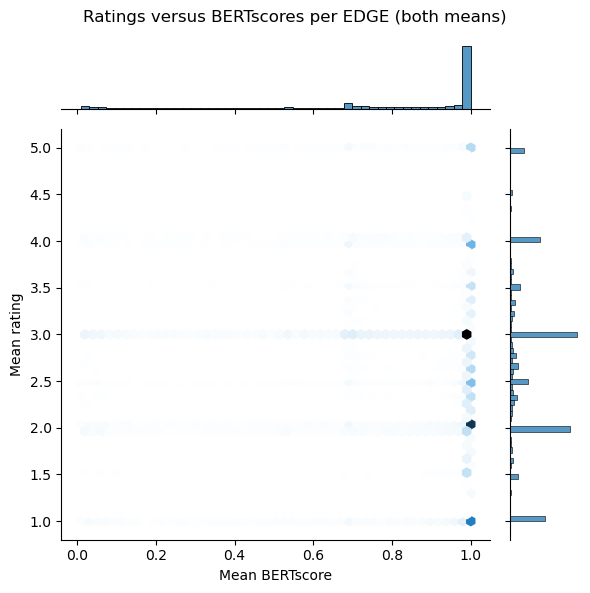

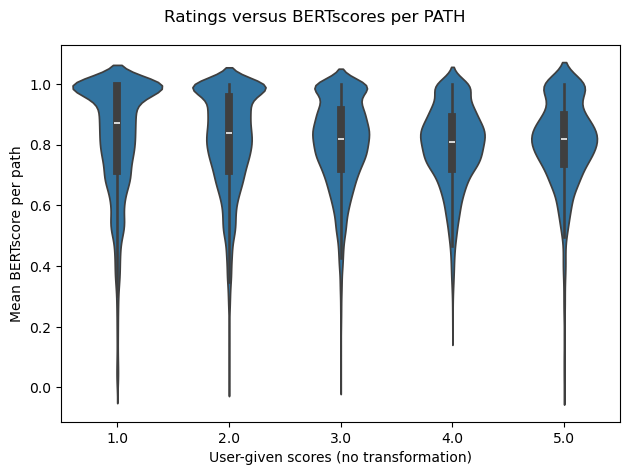

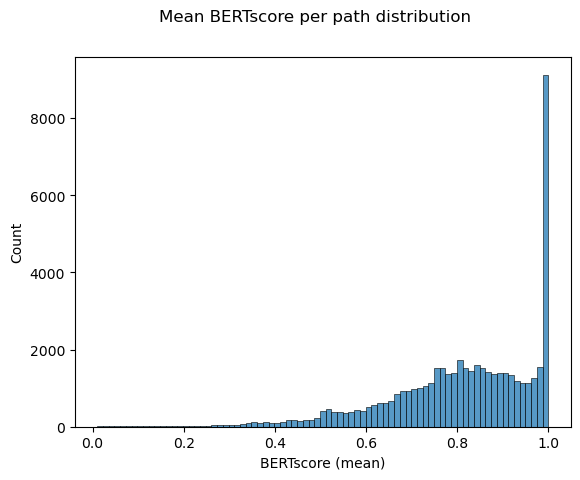

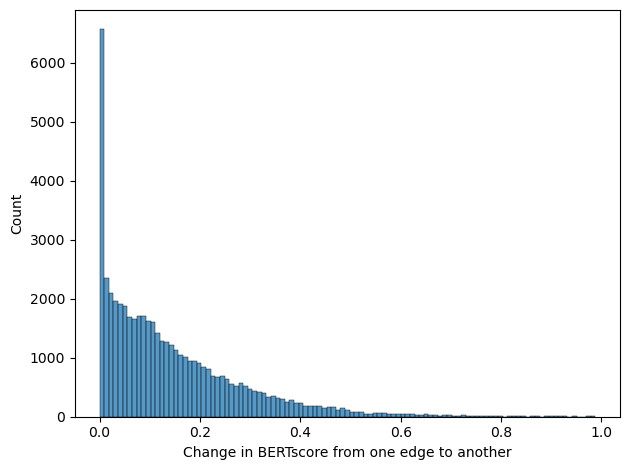

'Gaussianity' Shapiro test p-value for mean BERTscore per EDGE's histogram: 1.9635877044604022e-19


In [3]:

p4 = sns.jointplot(
    data=edge_score_df,
    x="mean_bert_score",
    y="mean_rating",
    kind="hex",
)
p4.figure.suptitle("Ratings versus BERTscores per EDGE (both means)")
plt.xlabel("Mean BERTscore")
plt.ylabel("Mean rating")
p4.figure.tight_layout()
plt.show()

mean_BERT_and_score = pd.DataFrame(
    {
        "successive_pairs_mean": sucessive_pairs_encoded_mean,
        "finished_scores": aligned_finished_scores,
    }
)

p6 = sns.violinplot(
    data=mean_BERT_and_score,
    x="finished_scores",
    y="successive_pairs_mean",
    # kind="kde"
)
p6.figure.suptitle("Ratings versus BERTscores per PATH")
plt.xlabel("User-given scores (no transformation)")
plt.ylabel("Mean BERTscore per path")
p6.figure.tight_layout()
plt.show()

# ------------------------------

p5 = sns.histplot(x=sucessive_pairs_encoded_mean)
p5.figure.suptitle("Mean BERTscore per path distribution")
plt.ylabel("Count")
plt.xlabel("BERTscore (mean)")
plt.show()

p7 = sns.histplot(x=np.abs(np.diff(sucessive_pairs_encoded_mean)))
p5.figure.suptitle("Incremental changes in pair semantic similarity")
plt.xlabel("Change in BERTscore from one edge to another")
plt.ylabel("Count")
p7.figure.tight_layout()
plt.show()

print(
    "'Gaussianity' Shapiro test p-value for mean BERTscore per EDGE's histogram:",
    scipy.stats.shapiro(
        np.histogram(edge_score_df["mean_bert_score"].to_numpy(), bins=80)[0]
    ).pvalue,
)

This data per path seems relatively gaussian, and both the edge and path metrics have interesting distributions both on their own and when compared. Our subsequent analysis should be interesting!